# Project Objective

The goal of this project is to explore housing data across different districts in California.  
By analyzing the dataset, i aim to understand the relationships between various features of the houses and their prices.  

In addition, i will implement a **linear regression model** to predict the price of a house based on its characteristics.

In [26]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


# Download the data 

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

/var/folders/tz/tl_w5k6s62vcg00cl2mjjbtc0000gn/T/ipykernel_8691/1387014147.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Study the Data

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### I should verify all the variables that will be important for the project . Thus i will take a closer look

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Looks like total_bedrooms don't have the same length of data as the other columns. 

### Also, ocean_proximity is the only object. It can be interesting to see what it is inside it 

In [7]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### It makes sense , many houses are close to the ocean. 

### Now i can look at all numbered data making histograms in order to identify what i could use to make my model

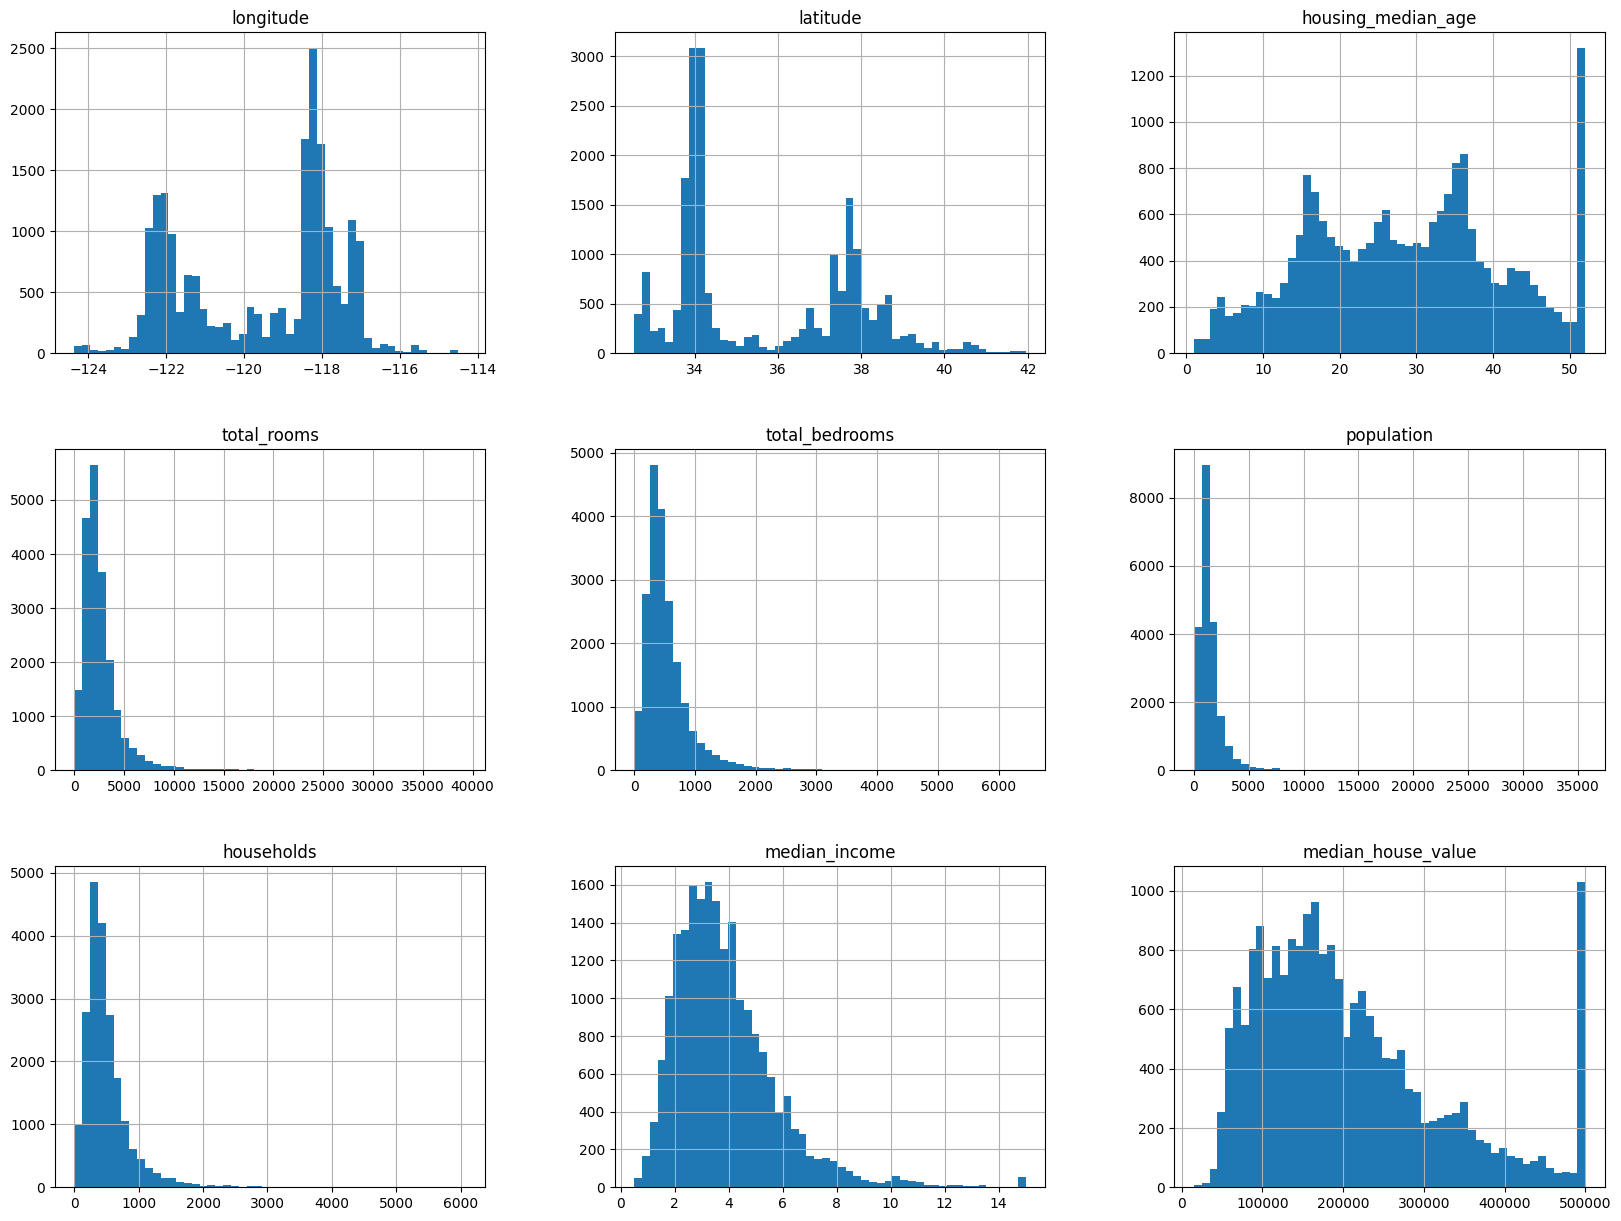

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Important to see if some data was already treated such as the median income and what are the units of these data

### Before looking any further ,i will set aside a test set in order to avoid data snooping bias

In [9]:
def split_train_test(data,ratio):
    shuffle = np.random.permutation(len(data))
    test_set_size= int(len(data)*ratio)
    test_indice = shuffle[:test_set_size]
    train_indice = shuffle[test_set_size:]
    return data.iloc[train_indice], data.iloc[test_indice]

In [10]:
train_set, test_set = split_train_test(housing,0.2)
len(train_set)

# Thus we have 20% test and 80% train 

16512

In [11]:
len(test_set)

4128

### This works but everytime i run this it will generate different sets

### I can save this first test and keep using it or just set a seed

### First it is important to see that this housing dataset does not have a identifier column

In [13]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### In order to set every index as unique , i should look in the features of the dataset 
### that can make this unique . Like the coordinates ! 

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [16]:
test_set.head()


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


### Now it is better to work with the data because i separated into 20% test and 80% training and i am using uniques lines ,setting an index using features that will not change and if i add new lines they will never have exatcly all the same features 

### Now i could just use the library of sklearn

In [18]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### Very important question : Is the test set representative of all the population ? is it stratification sampling?


<Axes: >

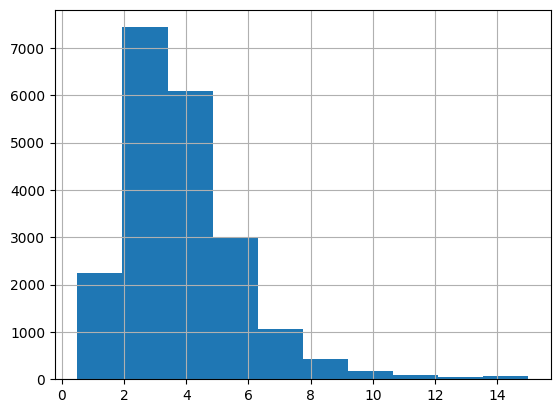

In [20]:
housing['median_income'].hist()

### I should create categories and sample trying to represent all population. Thus :

In [21]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins = [0., 1.5,3.0, 4.5, 6.,np.inf],
                               labels = [1,2,3,4,5])

<Axes: >

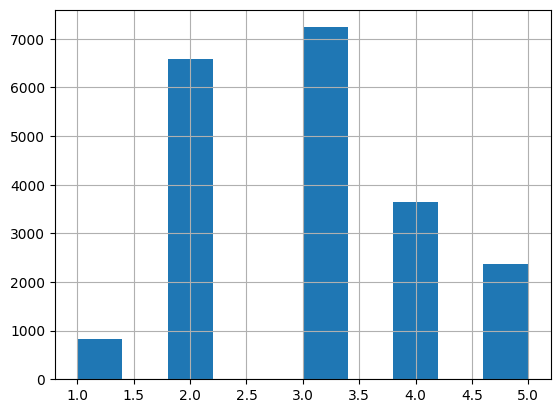

In [22]:
housing['income_cat'].hist()

In [24]:
housing['income_cat'].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

### Now that we know how test_set behaves, we can sample it trying to resume all the population

In [27]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [28]:
# I am dividng by the len of strat_test_set to get the value in percentage 
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [29]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

### So, with this we got a good stratified because the category and the test_set created have the sabe ratio for every index !! 

### Now we don't need the category anymore

In [30]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Now i can finally put the test_set aside and work with the training_set 

### Creating a copy of the training_set i can work with it without harm the original set